
### Problem Statement
The case business case is on the inventory management. Keeping Inventory of spare in various service centre to the market demand is always a challenge as most service centres spends significant amount in spare parts inventory costs. In spite of this, availability of spare parts is been one of the problem areas.

### Tasks
Create Predictive model for inventory forecasting so that 
service centre achieve JIT standards.

In [1]:
import mysql.connector as mysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Database connection details to import the data
host = "18.136.157.135"
port = 3306
database = "project_service_data"
user= "dm_usdata_sql"
password = "37z<49REb&mKnl4AV!vJ"

# Establish connection
conn = mysql.connect(host=host, user=user, password=password, database=database)

# Fetch data
query = "SELECT * FROM service_data"
dfInv = pd.read_sql(query, conn)

# Close connection
conn.close()

C:\Users\nakandinda\AppData\Local\Temp\ipykernel_24428\1305448106.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfInv = pd.read_sql(query, conn)


In [3]:
dfInv.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [4]:
dfInv.describe()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
count,28482,28482,28482,28482,28482,28482,28476
unique,555,553,1010,846,28,3474,503
top,01-12-18,01-12-18,venkXXXXXXXXXX,KA53EVXXXX,BAJAJ PULSAR 150,0,ENGINE OIL
freq,179,179,424,1313,8633,842,3802


In [5]:
#Checking for missing values
print(dfInv.isnull().sum())

invoice_date             0
job_card_date            0
business_partner_name    0
vehicle_no               0
vehicle_model            0
current_km_reading       0
invoice_line_text        6
dtype: int64


In [6]:
dfInv_null = dfInv[dfInv['invoice_line_text'].isnull()]
dfInv_null


,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
632,15-06-17,14-06-17,naveXXXXXXXXXX,KA53W3XXXX,BAJAJ DISCOVER 150,25677,None
635,15-06-17,14-06-17,naveXXXXXXXXXX,KA53W3XXXX,BAJAJ DISCOVER 150,25677,None
661,15-06-17,14-06-17,kailXXXXXXXXXX,KA01HNXXXX,BAJAJ PULSAR 150,8679,None
769,16-06-17,16-06-17,hariXXXXXXXXXX,KA53ESXXXX,BAJAJ AVENGER STREET,457,None
2579,01-08-17,01-08-17,hariXXXXXXXXXX,KA53EQXXXX,BAJAJ PULSAR 150,9677,None
2613,03-08-17,03-08-17,diliXXXXXXXXXX,KA53S3XXXX,BAJAJ V,251447,None


In [7]:
#Handling missing values
dfInv.dropna(inplace=True)

In [8]:
#Checking for confirmation
print(dfInv.isnull().sum())

invoice_date             0
job_card_date            0
business_partner_name    0
vehicle_no               0
vehicle_model            0
current_km_reading       0
invoice_line_text        0
dtype: int64


In [9]:
#Creating a new dataframe using a copy to keep the original dataset
df_cleaned = dfInv.copy()

In [10]:
#Converting date columns to datetime
for col in ['invoice_date', 'job_card_date']:
    df_cleaned[col] = pd.to_datetime(df_cleaned[col], errors='coerce')

In [11]:
# Aggregate Spare Parts Demand by Month
df_cleaned['invoice_month'] = df_cleaned['invoice_date'].dt.to_period('M')
spare_parts_demand = df_cleaned.groupby(['invoice_month', 'invoice_line_text']).size().unstack(fill_value=0)
spare_parts_demand

invoice_line_text,,10 SIZE NUT,12 SIZE BOLT,3M OIL,4 WAY SWITCH,6004 BEARING,6202 BEARING,6303 BEARING,8 SIZE BOLT,ACCELATOR CABLE,...,WIRING KIT,WIRING LABOUR,YOKE,YOKE LEVER,YOKE RUBBER,YOKE SET,bore kit,clutch cable,handle weight,tyre
invoice_month,,,,,,,,,,,,,,,,,,,,,
2017-01,0,0,0,19,0,0,0,0,0,0,...,1,1,0,0,0,0,0,3,0,0
2017-02,0,0,0,23,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2017-03,0,0,0,15,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2017-04,0,0,0,20,0,0,0,0,0,1,...,1,0,0,0,0,0,0,3,0,0
2017-05,0,0,0,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2017-06,1,0,0,73,0,0,0,0,0,3,...,0,0,3,0,0,0,1,7,0,0
2017-07,1,0,0,69,0,0,0,0,0,4,...,1,0,2,0,0,0,0,19,1,0
2017-08,0,0,0,47,0,0,0,0,0,2,...,0,0,2,0,0,0,1,16,1,0
2017-09,0,0,0,67,0,0,0,0,0,1,...,1,0,0,0,0,0,0,13,0,1


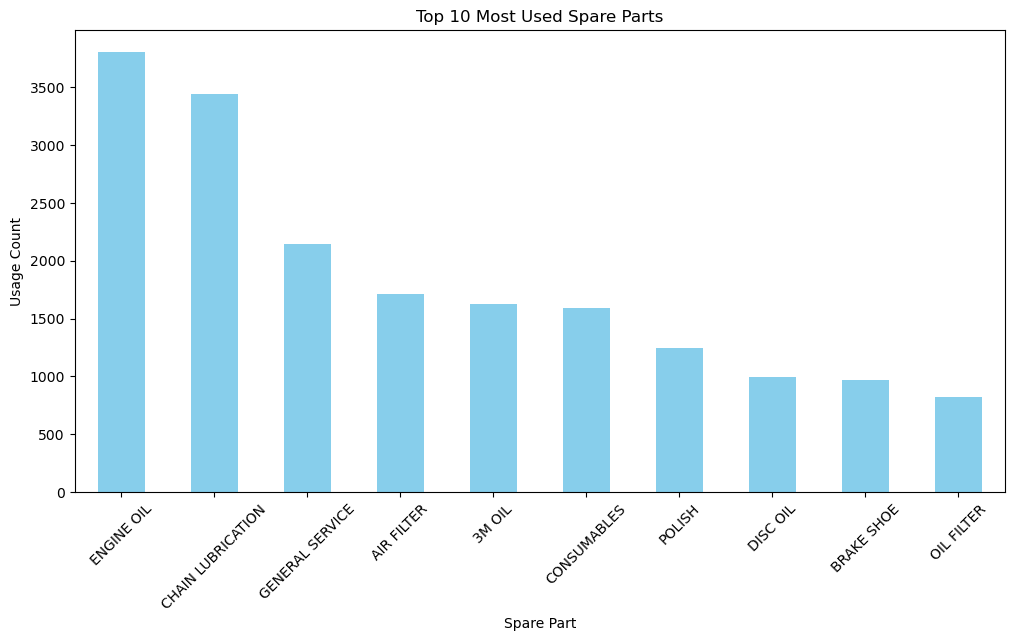

In [12]:
# Most Frequently Used Spare Parts
plt.figure(figsize=(12, 6))
df_cleaned['invoice_line_text'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Used Spare Parts')
plt.xlabel('Spare Part')
plt.ylabel('Usage Count')
plt.xticks(rotation=45)
plt.show()

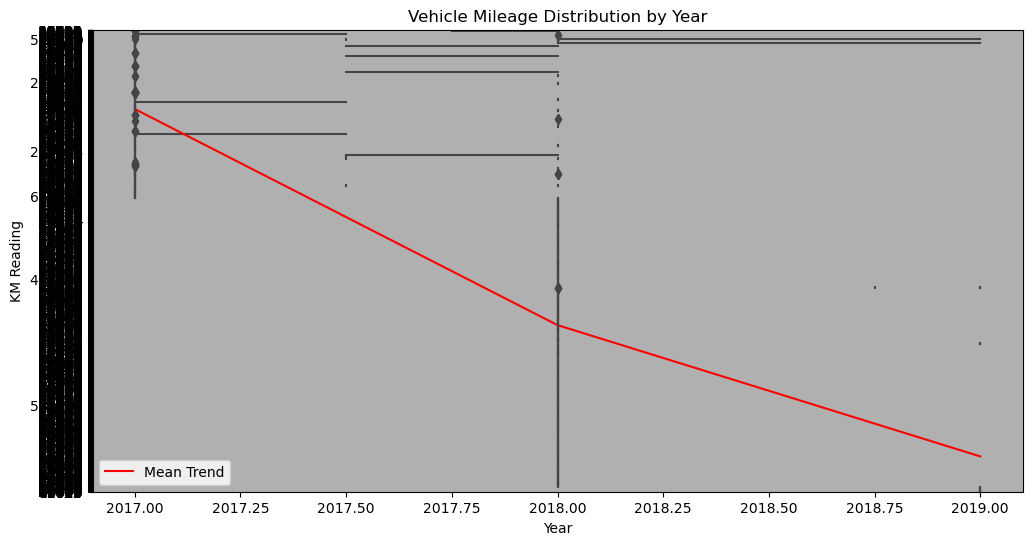

In [13]:
# Vehicle Mileage Distribution Over Time
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_cleaned['invoice_date'].dt.year, y=df_cleaned['current_km_reading'])
sns.lineplot(x=df_cleaned['invoice_date'].dt.year, y=df_cleaned['current_km_reading'], color='red', label='Mean Trend')
plt.title('Vehicle Mileage Distribution by Year')
plt.xlabel('Year')
plt.ylabel('KM Reading')
plt.grid()
plt.legend()
plt.show()

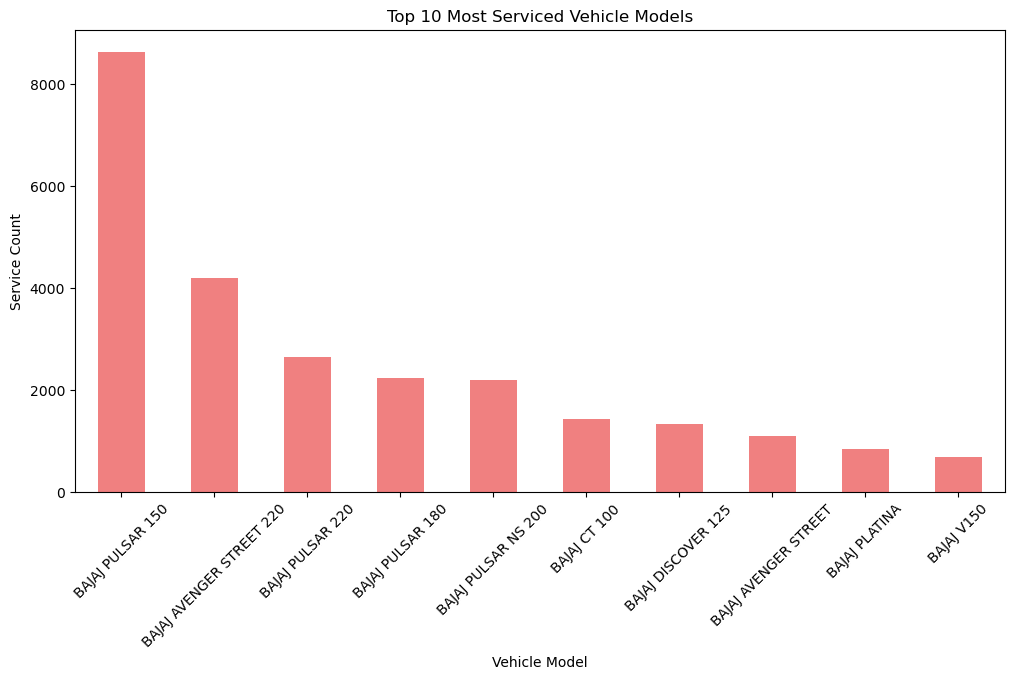

In [14]:
# Service Frequency by Vehicle Model
plt.figure(figsize=(12, 6))
df_cleaned['vehicle_model'].value_counts().head(10).plot(kind='bar', color='lightcoral')
plt.title('Top 10 Most Serviced Vehicle Models')
plt.xlabel('Vehicle Model')
plt.ylabel('Service Count')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Forecasting Preparation for the data that is train and test splitting
history = spare_parts_demand.sum(axis=1).astype(float)
train_size = int(len(history) * 0.8)
train, test = history[:train_size], history[train_size:]

In [16]:
# Ensuring sufficient data for seasonal cycles to counter wrong forecasts
seasonal_periods = 12 if len(train) >= 24 else max(2, len(train) // 2)

# Exponential Smoothing Model (Holt-Winters)
hw_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(steps=len(test))
hw_forecast

2018-12    1933.517169
2019-01    2055.561022
2019-02    2331.800647
2019-03    2305.656186
2019-04    2707.770503
2019-05    2646.647445
Freq: M, dtype: float64

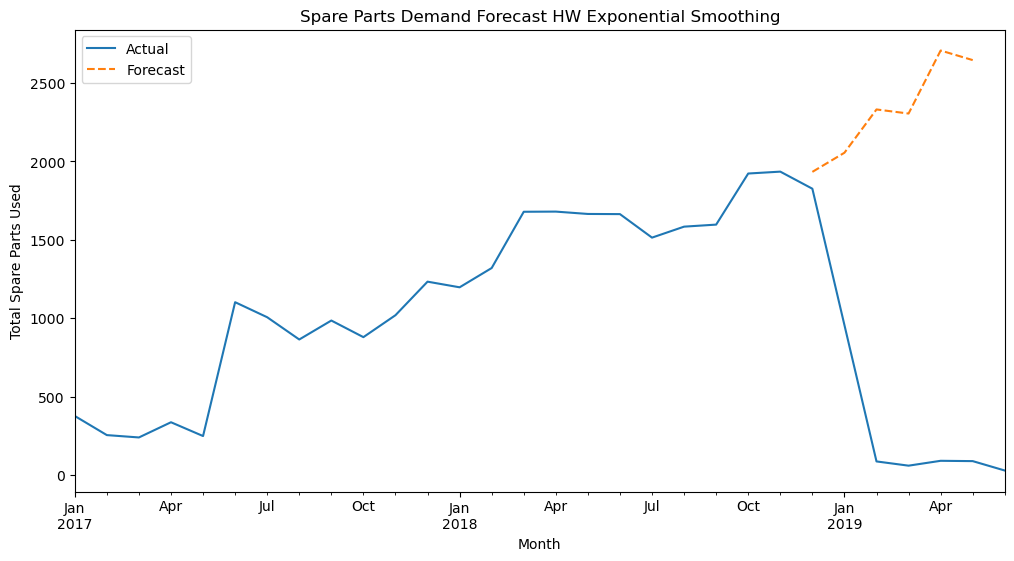

In [17]:
# Plotting Forecast for exponential smoothing
plt.figure(figsize=(12, 6))
history.plot(label='Actual')
hw_forecast.plot(label='Forecast', linestyle='dashed')
plt.title('Spare Parts Demand Forecast HW Exponential Smoothing')
plt.xlabel('Month')
plt.ylabel('Total Spare Parts Used')
plt.legend()
plt.show()

In [18]:
# Calculate MAE and RMSE for exponential smoothing
mae = mean_absolute_error(test, hw_forecast)
rmse = np.sqrt(mean_squared_error(test, hw_forecast))
print(f"Mean Absolute Error (MAE) HW: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) HW: {rmse:.2f}")

Mean Absolute Error (MAE) HW: 1967.33
Root Mean Squared Error (RMSE) HW: 2148.10


In [19]:
# Fitting ARIMA model
model = ARIMA(train, order=(5,1,0))
fit_model = model.fit()
arima_forecast = fit_model.forecast(steps=len(test))
arima_forecast

2018-12    1867.383187
2019-01    1925.631478
2019-02    1868.417367
2019-03    1933.169594
2019-04    1957.447668
2019-05    1917.803481
Freq: M, Name: predicted_mean, dtype: float64

Mean Absolute Error (MAE) ARIMA: 1548.81
Root Mean Squared Error (RMSE) ARIMA: 1689.35


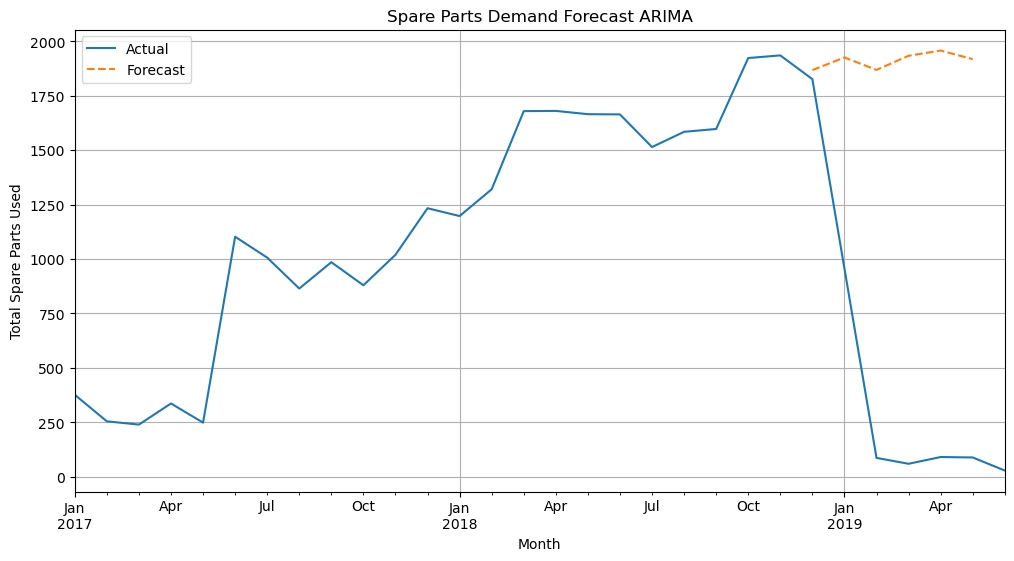

In [20]:
# Calculate MAE and RMSE
mae = mean_absolute_error(test, arima_forecast)
rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print(f"Mean Absolute Error (MAE) ARIMA: {mae:.2f}")
print(f"Root Mean Squared Error (RMSE) ARIMA: {rmse:.2f}")

# Plotting ARIMA Forecast
plt.figure(figsize=(12, 6))
history.plot(label='Actual')
arima_forecast.plot(label='Forecast', linestyle='dashed')
plt.title('Spare Parts Demand Forecast ARIMA')
plt.xlabel('Month')
plt.ylabel('Total Spare Parts Used')
plt.legend()
plt.grid()
plt.show()

### Comparison between the two models

##### MAE Comparison:
ARIMA has a lower MAE (1548.81) compared to Exponential Smoothing (1967.33).
This indicates that, on average, ARIMA's predictions are more accurate than Exponential Smoothing's predictions.

##### RMSE Comparison:
ARIMA also has a lower RMSE (1689.35) compared to Exponential Smoothing (2148.10).
This suggests that ARIMA is making smaller large errors than Exponential Smoothing.

##### Conclusion
Based on both MAE and RMSE, the ARIMA model outperforms the Exponential Smoothing model in this case. ARIMA provides more accurate average predictions and also reduces the impact of large errors.

In the context of the project goal (achieving JIT standards in spare parts inventory management), the ARIMA model is likely to be more effective due to its lower error metrics.

##### Further Analysis
More analysis should focus on how to improve the ARIMA model for better forecasting, since both models struggle with capturing the sharp drop in demamd after January 2019.
The sharp drop might have been due to external events eg policy change or supply disruptions that need to be further investigated.
